In [1]:
import os, time
import numpy as np
from copy import deepcopy
import pickle
from tqdm import tqdm

# Pytorch
import torch
use_cuda = True
if torch.cuda.is_available() and use_cuda:
    device = torch.device('cuda')
    print("Use cuda.")
else:
    device = torch.device('cpu')
    print("Use cpu.")
to_dev = lambda arr: (torch.from_numpy(arr).to(device)
                       if type(arr) == np.ndarray else arr.to(device))
from torch.optim import Adam, SGD

# Figures 
from specs import *
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from helpers import copy_sd
from rnn_model_dt import RNN_Net
from task_generators import cycling
task_generator = cycling
task_name = "cycling"
dim_in = 2
dim_out = 2

Use cpu.


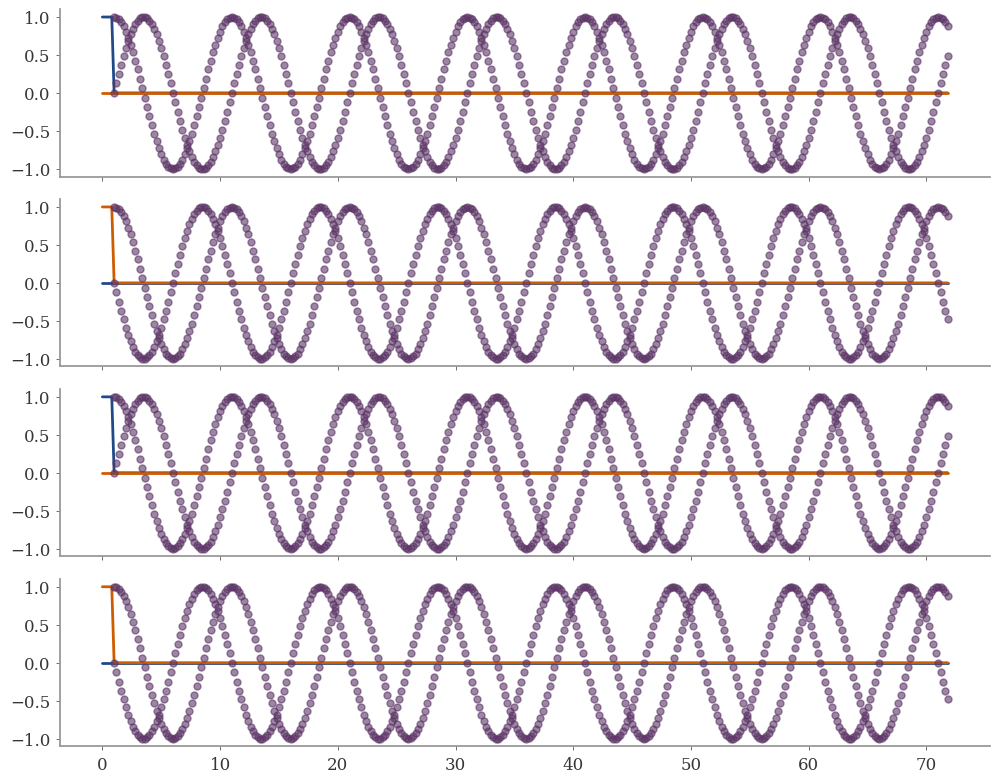

In [2]:
# Parameters
n_samples = 1

# Network
dim_hid = 256
n_layers = 2
bias = False
train_in = False
train_hid = True
train_out = False
train_layers = [train_in, train_hid, train_out]
nonlin = torch.nn.Tanh()
gaussian_init = True
h_0_std = 1.
dt = 0.2
rec_step_dt = 1
mask_step_dt = 1
batch_size = 32
task_params = dict(
    rec_step_dt=rec_step_dt,
    mask_step_dt=mask_step_dt,
)
# Noise on input, h_0, and hidden states
noise_input_std = 0.0
noise_init_std = 1.0
noise_hid_std = 0.2

# Joint scenarios
out_scales = ['large']
gs = [1.5]
n_sce = len(out_scales)
opt_gens = [Adam]*n_sce
n_mi = n_samples, n_sce

# Task and training
n_steps = 5001
lr0s = [0.1]*n_sce

# Task generators and fixed eval task
task_gen = task_generator(dim_in, dim_out, dt, **task_params)
task_params_ev = deepcopy(task_params)
task_gen_ev = task_generator(dim_in, dim_out, dt, **task_params_ev)
ts_ev, input_ev, target_ev, mask_ev = task_gen_ev(batch_size)
noise_input_ev = noise_input_std * np.float32(np.random.randn(*input_ev.shape)) / np.sqrt(dt)
noise_init_ev = noise_init_std * np.float32(np.random.randn(n_layers-1, batch_size, dim_hid)) 
n_t_ev = len(ts_ev)
task_ev = ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev

# Plot the task
n_show = min(4, batch_size)
n_cols = 1
n_rows = n_show
fig = plt.figure(figsize=(10, 2 * n_rows))
axes = subplots(fig, n_rows, n_cols, sharey=True, sharex=True)
for i_b in range(n_show):
    ax = axes[i_b, 0]
    # Input
    for i_in in range(dim_in):
        ax.plot(ts_ev, (input_ev + noise_input_ev)[i_b, :, i_in], "-", c=colors[i_in])
    # Target
    for i_out in range(dim_out):
        c = colors[4]
        m = mask_ev[i_b, :, i_out]
        ax.plot(ts_ev[m], target_ev[i_b, :, i_out][m], 'o', ms=5, c=c, alpha=0.6)
fig.tight_layout()
plt.show()

In [3]:
##############################################################################
# Train networks
# Loss
loss_crit = torch.nn.MSELoss()

# Results arrays
n_if = 2
n_ifn = 4
steps = torch.arange(n_steps)
loss_all = torch.zeros((*n_mi, n_steps))
output_all = torch.zeros((n_ifn, *n_mi, batch_size, n_t_ev, dim_out))
hids_all = torch.zeros((n_ifn, *n_mi, batch_size, n_t_ev, dim_hid))
h_0_all = torch.zeros((*n_mi, n_layers-1, batch_size, dim_hid))
sd_if_all = np.zeros((n_if, *n_mi), dtype=object)
loss_bias_all = torch.zeros((*n_mi, n_steps))
loss_var_all = torch.zeros((*n_mi, n_steps))

# Record during training?
rec_step_width = 100
n_rec_steps = int(np.ceil(n_steps / rec_step_width))
rec_steps = torch.arange(0, n_steps, rec_step_width)
output_rec_all = torch.zeros((*n_mi, n_rec_steps, batch_size, n_t_ev, dim_out))
w_rec_all = torch.zeros((*n_mi, n_rec_steps, dim_hid, dim_hid),)

# Task to device
ts_ev, input_ev, target_ev, mask_ev, noise_input_ev, noise_init_ev = [to_dev(arr) for arr in task_ev]

# Run
time0 = time.time()
for mi in np.ndindex(*n_mi):
    i_s, i_sce = mi
    out_scale = out_scales[i_sce]
    g = gs[i_sce]
    lr0 = lr0s[i_sce]
    opt_gen = opt_gens[i_sce]
    # Network instance
    net = RNN_Net(dim_in, dim_hid, dim_out, n_layers, nonlin, bias, out_scale, g, gaussian_init, 
                  dt, rec_step_dt, train_layers)
    net.to(device)
    # Initial state: the same for each batch!
    h_0 = h_0_std * torch.randn((n_layers - 1, 1, dim_hid), device=device)
    h_0 = torch.tile(h_0, (1, batch_size, 1))
    h_0_all[mi] = h_0.detach()

    # Optimizer
    if opt_gen == torch.optim.Adam:
        lr = lr0 / dim_hid
    else:
        lr = lr0
    opt = opt_gen(net.parameters(), lr=lr)

    # Save before training
    sd_if_all[0][mi]= copy_sd(net.state_dict)
    with torch.no_grad():
        # With noise
        output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                       h_0 + noise_init_ev, 
                                       noise_hid_std, last_time=False)
        output_all[0][mi] = output
        hids_all[0][mi] = hids[0]
        # No noise
        output, hids = net.forward_hid(input_ev, h_0, last_time=False)
        output_all[2][mi] = output
        hids_all[2][mi] = hids[0]

    # Train
    for step in tqdm(range(n_steps)):
        # Record
        # 500 iterations took 24 sec each without recording; 32 sec with
        if step % rec_step_width == 0:
            rec_step = step // rec_step_width
            with torch.no_grad():
                # Save noisy output at regular intervalls
                output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                               h_0 + noise_init_ev, 
                                               noise_hid_std, last_time=False)
                output_rec_all[mi][rec_step] = output
                w_rec_all[mi][rec_step] = net.rnn.weight_hh_l0
                
                
        opt.zero_grad()
        # Draw an independent task each time
        task = task_gen(batch_size)
        _, input, target, mask = [to_dev(arr) for arr in task]
        # Draw independent input noise every time!
        noise_init = noise_init_std * torch.randn_like(h_0)
        noise_input = noise_input_std * torch.randn_like(input) / np.sqrt(dt)
        output = net(input + noise_input, h_0 + noise_init, noise_hid_std)
        loss = loss_crit(output[mask], target[mask])
        loss.backward()
        opt.step()
        loss_all[mi][step] = loss.item()
        
        with torch.no_grad():
            # Compute L_bias and L_var
            d_out = (output - target)
            d_out_mean = d_out.mean(0)[mask[0]]
            d_out_fluc = (d_out - d_out.mean(0))[mask]
            loss_bias_all[mi][step] = loss_crit(d_out_mean, 0*d_out_mean)
            loss_var_all[mi][step] = loss_crit(d_out_fluc, 0*d_out_fluc)

    # Save after training
    sd_if_all[1][mi] = copy_sd(net.state_dict)
    with torch.no_grad():
        # With noise
        _, input, target, mask = [to_dev(arr) for arr in task]
        output, hids = net.forward_hid(input_ev + noise_input_ev, 
                                       h_0 + noise_init_ev, 
                                       noise_hid_std, last_time=False)
        output_all[1][mi] = output
        hids_all[1][mi] = hids[0]
        # No noise
        output, hids = net.forward_hid(input_ev, h_0, last_time=False)
        output_all[3][mi] = output
        hids_all[3][mi] = hids[0]
print("Took %.1f sec." % (time.time() - time0))


100%|█████████████████████████████████████████████████████| 5001/5001 [52:57<00:00,  1.57it/s]

Took 3178.6 sec.


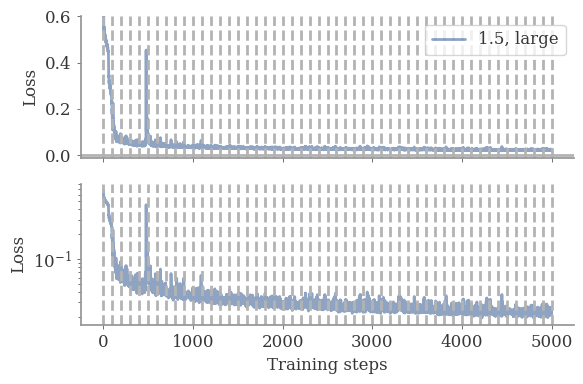

In [4]:
# Plot learning curves 
lbl_sce = ["%.1f, %s" % (gs[i_sce], out_scales[i_sce]) for i_sce in range(n_sce)]
n_rows = 2
n_cols = 1
fig = plt.figure(figsize=(6, 4))
axes = subplots(fig, n_rows, n_cols, sharex=True)
for i_r in range(n_rows):
    for mi in np.ndindex(*n_mi):
        i_s, i_sce = mi
        c = colors[i_sce]
        ax = axes[i_r, 0]
        loss = loss_all[mi]
        lbl = lbl_sce[i_sce] if i_s == 0 else None
        ax.plot(steps, loss, c=c, label=lbl, alpha=0.5)
    for rec_step in rec_steps:
        ax.axvline(rec_step, ls='--', c=c_leg)
    ax.set_ylabel("Loss")
ax = axes[0, 0]
ax.legend(ncol=2)
ax.axhline(0, c=c_leg, zorder=-1)
ax.set_ylim(-0.01, 0.6)
# ax.set_ylim(-0.01, 0.02)
ax = axes[1, 0]
ax.set_yscale("log")

ax.set_xlabel("Training steps")
fig.tight_layout()

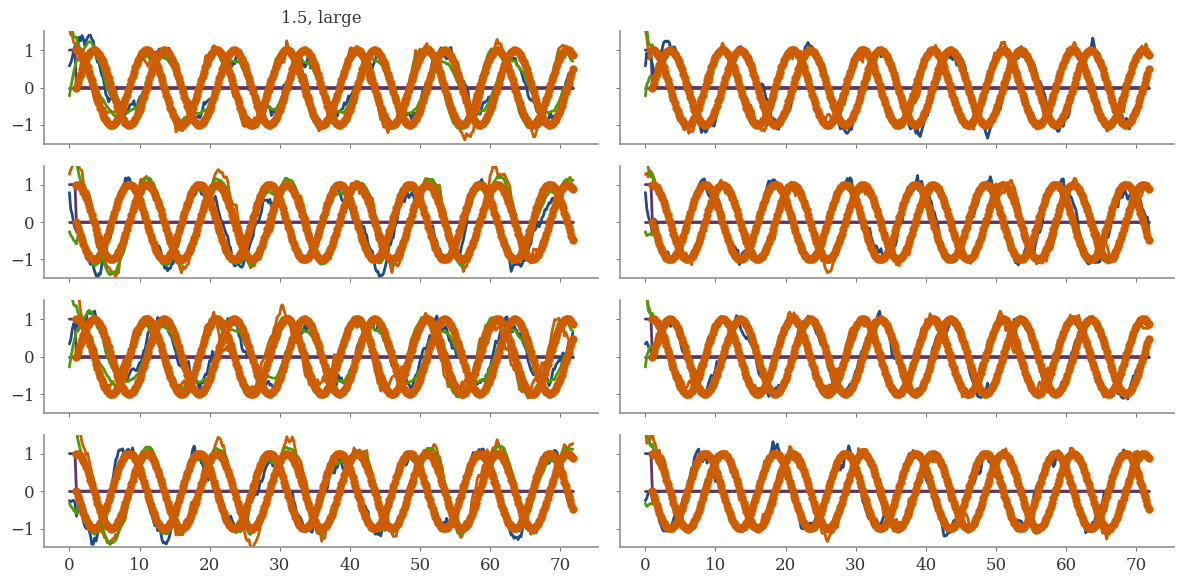

In [5]:
# Plot the task
n_show = min(batch_size, 4)
rec_show = np.array([5, n_rec_steps-1])
n_rec_show = len(rec_show)

fig = plt.figure(figsize=(12, 1.5 * n_show))
n_cols = n_rec_show
n_rows = n_show
axes = subplots(fig, n_rows, n_cols, sharey=True, sharex=True)

# for mi in np.ndindex(*n_mi):
#     i_s, i_sce = mi
ts_ev, input_ev, target_ev, mask_ev, _, _ = task_ev
for i_r, i_c in np.ndindex(n_rows, n_cols):
    ax = axes[i_r, i_c]
    i_b = i_r
    i_rec = rec_show[i_c]
    i_s = 0
    i_sce = 0
    mi = i_s, i_sce
    # Input
    for i_in in range(dim_in):
        ax.plot(ts_ev, input_ev[i_b, :, i_in], c=colors[4])
    for i_out in range(dim_out):
        c = colors[i_out]
        # Output
        output = output_rec_all[mi][i_rec]
        ax.plot(ts_ev, output[i_b, :, i_out], '-', c=c)
        # Average output for this target 
        ax.plot(ts_ev, output[i_b::dim_out, :, i_out].mean(0), '-', c=colors[2], alpha=1.)
        # Target
        m = mask_ev[i_b, :, i_out]
        ax.plot(ts_ev[m], target_ev[i_b, :, i_out][m], 'o', ms=5, c=colors[1])
        
            
        ax.set_ylim(-1.5, 1.5)
    ax = axes[0, i_sce]
    lbl = "%.1f, %s" % (gs[i_sce], out_scales[i_sce])
    ax.set_title(lbl)
fig.tight_layout()

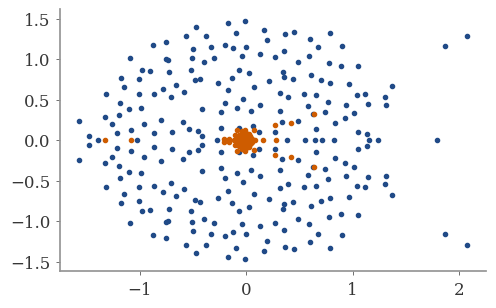

In [6]:
w_rec = sd_if_all[1][mi]["rnn.weight_hh_l0"]
ew = torch.linalg.eigvals(w_rec)
plt.plot(ew.real, ew.imag, 'o')
dw_rec = w_rec - sd_if_all[0][mi]["rnn.weight_hh_l0"]
ew = torch.linalg.eigvals(dw_rec)
plt.plot(ew.real, ew.imag, 'o')

Loss 0: tensor(0.6834)
Save figure to ../figures/fig_21_noise_compression_cycling.both


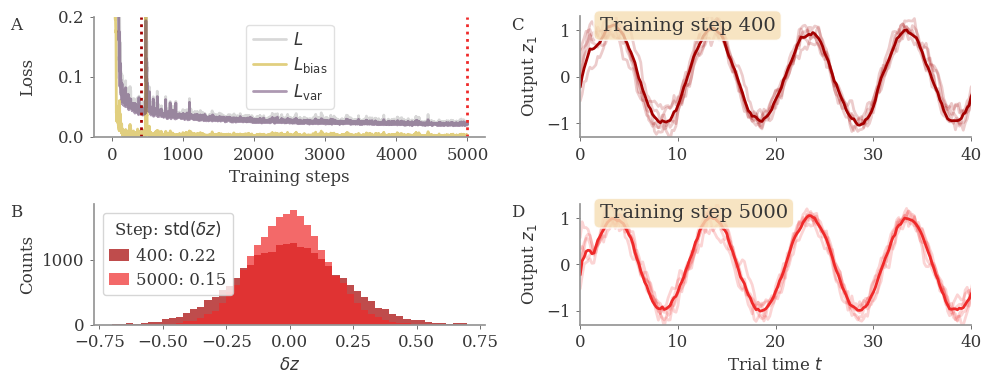

In [19]:
# Compare trajectories and fluctuations around average for two time points during learning
# Select epochs to show
rec_show = np.array([4, n_rec_steps-1])
n_rec_show = len(rec_show)
cs_show = colors[[0, 2]]
cs_show = cs[3, [0, 2]]

n_rows = 2
n_cols = 2
fig = plt.figure(figsize = (10, 4))
axes = subplots(fig, n_rows, n_cols)

i_s = 0
i_sce = 0
mi = i_s, i_sce


### Loss
ax = axes[0, 0]
alpha = 0.5
ax.plot(steps, loss_all[mi], c=c_leg, label=r"$L$", alpha=alpha)
ax.plot(steps, loss_bias_all[mi], c=colors[5], label=r"$L_\mathrm{bias}$", alpha=alpha)
ax.plot(steps, loss_var_all[mi], c=colors[4], label=r"$L_\mathrm{var}$", alpha=alpha)
for i_r in range(n_rec_show):
    rec_step = rec_steps[rec_show[i_r]]
    ax.axvline(rec_step, ls=':', c=cs_show[i_r])
ax.set_ylabel("Loss")
ax.set_ylim(0, 0.2)
ax.set_xlabel("Training steps")
ax.legend(loc=9, ncol=1, 
    labelspacing=0.4, handlelength=2., handletextpad=0.4, columnspacing=0.5,
    frameon=True, framealpha=0.6, markerscale=1,
    # bbox_to_anchor=(1, 0)
             )

### Trajectories
i_c = 1
ts_ev, input_ev, target_ev, mask_ev, _, _ = task_ev
i_b = 0
for i_r in range(n_rows):
    ax = axes[i_r, i_c]
    i_rec = rec_show[i_r]
    # Output
    i_out = 0
    c = cs_show[i_r]
    output = output_rec_all[mi][i_rec]
    plot_samples(ax, ts_ev, output[i_b:10:2, :, i_out], '-', c=c, mode="all", alpha=0.2)#, label="Examples")
    # Average output for this target
    ax.plot(ts_ev, output[i_b::2, :, i_out].mean(0), '-', c=c, alpha=1.)#, label="Trial avg.")
    # Target
    m = mask_ev[i_b, :, i_out]
    ax.set_ylim(-1.3, 1.3)
    ax.set_ylabel("Output $z_1$")
    ax.set_xlim(0, 40)
    lbl = "Training step %d" % rec_steps[i_rec]
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)#cs[[0, 2][i_r], 2], alpha=1.)
    ax.text(0.05, 1., lbl, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Trial time $t$")
    
### Distribution of output fluctuations
ax = axes[1, 0]
for i_r in range(n_rows):
    i_rec = rec_show[i_r]
    c = cs_show[i_r]
    d_out = (output_rec_all[mi][i_rec].numpy() - target_ev)[mask_ev]
    xmax = 0.7
    bins = np.linspace(-xmax, xmax, 51)
    lbl = r"%d: %.2f" % (rec_steps[i_rec], d_out.std())
    ax.hist(d_out, bins, color=c, lw=0, alpha=0.7, label=lbl)
ax.set_xlabel(r"$\delta z$")
ax.set_ylabel("Counts")
ax.legend(loc=2, ncol=1, 
    # title = r"$\sigma_{\delta z}$", 
    title = r"Step: $\mathrm{std}(\delta z)$", 
    title_fontsize=fs,
    labelspacing=0.4, handlelength=1.2, handletextpad=0.4, columnspacing=0.5,
    frameon=True, framealpha=0.8, markerscale=1,)

if n_cols > 2:
    ### Eigenvalue spectra
    i_c = 2
    ews = torch.linalg.eigvals(w_rec_all[mi][rec_show])
    xmin = ews.real.min() * 1.1
    xmax = ews.real.max() * 1.1
    ymax = ews.imag.max() * 1.1
    for i_r in range(n_rows):
        ax = axes[i_r, i_c]
        c = cs_show[i_r]
        i_rec = rec_show[i_r]
        ew = torch.linalg.eigvals(w_rec_all[mi][i_rec])
        ax.plot(ew.real, ew.imag, 'o', c=c)

        ax.set_xlim(xmin, xmax)
        ax.set_ylim(-ymax, ymax)
        ax.set_aspect("equal")
        ax.axhline(0, c=c_leg, zorder=-1, lw=1, )
        ax.axvline(0, c=c_leg, zorder=-1, lw=1)
        ax.set_ylabel(r"Im $\lambda(W)$")
    ax.set_xlabel(r"Real part $\lambda(W)$")

# Label plots
for i_r, i_c in np.ndindex(n_rows, n_cols):
    i = i_r + i_c * n_rows
    ax = axes[i_r, i_c]
    if i < n_rows:
        xpos = -0.2
    else:
        xpos = -0.16
    ypos = 1.0
    ax.text(xpos, ypos, flbs[i], fontsize=fs, ha='center', va='top', transform=ax.transAxes)

# fig.align_labels(axes)
fig.align_ylabels(axes[:, 0])
fig.tight_layout()

print("Loss 0:", loss_all[mi][0])

fig_name = ("fig_21_noise_compression_%s" % task_name).replace('.', '_')
saving_fig(fig, figure_path, fig_name, data_type='both')